# Problem 1: Linear Regression Implementation

Using only Python libraries included in a standard Python install (e.g. not numpy, scipy, scikit-learn, etc.), write python function that implements a simple OLS regression. It should take an array-like object containing some number of observations of a single regressor and an array-like object containing the dependant variable values as inputs and return an array containing the slope and intercept as an output. In a Python shell (attach the output) or an IPython notebook, demonstrate your code’s functionality and compare it to an existing OLS implementation.

## 1.1 Solution to Problem 1

In order to find the best fit of the linear equation:

**Y = X * beta**

Normal Equation is the quick way to calculate the parameters:

**beta = (X'X)^(-1) \* X' \* Y**

where **beta'** = (intercept b0, slope b1, slope b2), and column vectors of **X** = (1, x1, x2, x3).

Since there is no matrix inverse function in the standard Python install, I use **Gradient Descent** to find the optimal coef beta.

The sample data here has only one feature. In principle we can apply the OLS algorithm to the regression problems with multiple features.

In [1]:
%matplotlib inline 

import csv
import copy
from matplotlib import pyplot as plt

In [2]:
def loadCSV(filename): 
    dataset = []
    with open(filename, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')

        for row in reader:    
            dataset.append(map(float, row))
        
    return dataset


In [3]:
def dot_product(vec1, vec2):
    assert len(vec1) == len(vec2), 'The size of two vectors does not match!'
    
    prod = 0.0
    for i in xrange(len(vec1)):
        prod += vec1[i] * vec2[i]
        
    return prod


In [4]:
def linear_regression(x_, y_, alpha=0.1, iters=10):
    # adding the the dummy column vector with all '1' which is for the intercept fit
    for i in xrange(len(x_)):
        x_[i].append(1.0)
    
    # define the data size: M -- sample size, N -- feature size
    M = len(x_)
    N = len(x_[0])
    
    # initialize OLS coefs as '0'
    beta = [0.0] * N
    
    def gradient_updates(beta_):

        for j in xrange(N):

            sum_gradient = 0.0

            for i in xrange(M):
                sum_gradient += (dot_product(beta_, x_[i]) - y_[i][0]) * x_[i][j] 
            beta_[j] = beta_[j] - alpha / float(M) * sum_gradient

        return beta_
    
    for it in xrange(iters):
        beta = gradient_updates(beta[:])
        
        if it%500==0:
            print 'Iteration = {}:'.format(it), beta
    
    return beta

In [5]:
def lr_predict(coef, vector):
    if type(vector) == float or type(vector) == int:
        vector = list([vector])
    
    vector.append(1.0)
    
    return dot_product(coef, vector)

In [6]:
# main
x = loadCSV('/Users/syan/Desktop/Document/ex2Data/ex2x.dat')
y = loadCSV('/Users/syan/Desktop/Document/ex2Data/ex2y.dat')

# learning rate
learning_rate = 0.04

# total iteration round
rounds = 5000

lr_coef = linear_regression(copy.deepcopy(x), copy.deepcopy(y), alpha=learning_rate, iters=rounds)

print
print 'Linear Regression model fitted coefs:'
print 'slope =', lr_coef[:-1]
print 'intercept =', lr_coef[-1]

Iteration = 0: [0.21715524143303216, -0.00017973622770281087]
Iteration = 500: [0.07955983965889724, 0.6639983388835929]
Iteration = 1000: [0.06568223329564456, 0.7402645356814631]
Iteration = 1500: [0.06408806113250035, 0.7490255168436025]
Iteration = 2000: [0.06390493265780359, 0.7500319232745775]
Iteration = 2500: [0.0638838960100561, 0.7501475329175579]
Iteration = 3000: [0.06388147945223141, 0.7501608134264444]
Iteration = 3500: [0.06388120185326285, 0.7501623390078027]
Iteration = 4000: [0.06388116996443878, 0.750162514256997]
Iteration = 4500: [0.06388116630125099, 0.7501625343885235]

Linear Regression model fitted coefs:
slope = [0.0638811658806839]
intercept = 0.7501625367


## 1.2 Sanity Check -- SKlearn LinearRegression

The slope and intecept of the OLS implementation match those of SKlearn Linear Regression.

In [7]:
import pandas as pd
from sklearn.linear_model import LinearRegression

x_pd = pd.DataFrame(x, columns=['x'])
y_pd = pd.DataFrame(y, columns=['label'])

lr = LinearRegression()
lr.fit(x_pd , y_pd)

print 'SKlearn Linear Regression model fitted coefs:'
print 'slope =', lr.coef_
print 'intercept =', lr.intercept_

SKlearn Linear Regression model fitted coefs:
slope = [[ 0.06388117]]
intercept = [ 0.75016254]


## 1.3 Visualize the fitting results

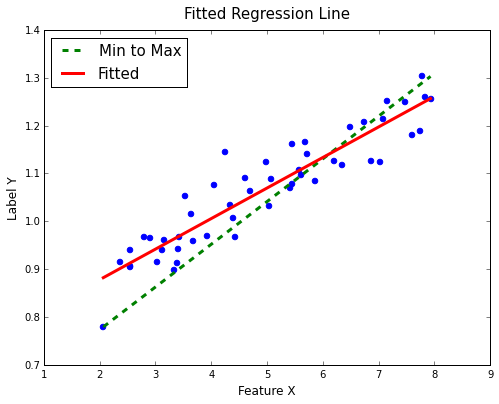

In [8]:
plt.figure(figsize=(8,6))

plt.scatter(x_pd, y_pd, color='blue', s=30)
plt.plot([x_pd['x'].min(), x_pd['x'].max()], 
         [y_pd['label'].min(), y_pd['label'].max()], 
         '--', lw=3, color='green', label='Min to Max')

plt.plot([x_pd['x'].min(), x_pd['x'].max()], 
         [lr_predict(lr_coef, x_pd['x'].min()), lr_predict(lr_coef, x_pd['x'].max())], 
         'k-', lw=3, color='red', label='Fitted')

plt.title('Fitted Regression Line', y=1.02, fontsize=15)
plt.xlabel('Feature X', fontsize=12)
plt.ylabel('Label Y', fontsize=12)
plt.legend(fontsize=15, loc='best')
plt.show()

# Problem 2: Gaussian Naive Baysian Classifier

Write a Python class that implements Naive Bayes Classification using a simple gaussian likelihood function. It should conform to the specification provided below. In addition to implementing the class, you should demonstrate this functionality in a Python shell (attach the output) or IPython notebook - a good test dataset for classification is the Pima Indian Diabetes dataset (accessible for free at multiple sites):

    a. A new classifier can be instantiated with the function call NaiveBayes(some_data_file.csv), where some_data_file.csv is formatted as feature_1, feature_2, ... , feature_N, category and contains the initial set of observations to classify on. You can assume the features are all floating point numbers and the categories are integers.
    
    b. it has a method called predict which takes an array of length N (where N is the number of features) and returns the most likely output category.
    
    c. it has a method called observe which takes two parameters; an array of length N and an integer category. This method should add this data to the classifier and revise its future predictions.

## 2.1 Solution to Problem 2

Supposed we have the data with N samples, and the class labels Y having k classes {class 0, class 1,..., class k}. Each sample data belongs to one of the classes. The data can be described by the feature matrix X:

**X = {X_1, X_2, X_3, ...., X_k}**

where x_i is the column vectors, k is the total number of the features.

Bayers' theorem can be expressed as following: 

**P(Y|X) = P(X|Y) * P(Y) / P(X)**

where P(Y|X) is the posterior, P(X|Y) is called the event model that is Gaussian Distribution in our case, and P(Y) = prior probability of the classes. P(X) does not depend on class Y, and thus is constatnt.

Naive Bayer Assumption means the conditional independence:

**P(X|Y) = P(X_1, X_2, X_3,..., X_k|y) = P(X_1|Y) \* P(X_2|Y) \* ..... \* P(X_k|Y)**

We are going to solve the optimization problem below:

**Y_estimate = argmax P(Y) \* P(parameters, X_1|Y) \* P(parameters, X_2|Y) \* ..... \* P(parameters, X_k|Y)**

where the parameters are the mean and variances of the Gaussian Distributions for all features X. 

The optimal paramters are the sample means and variances of the each features with respect to **Maximum Likelihood Estimation**. Please refer to wikepedia for more information:

https://en.wikipedia.org/wiki/Naive_Bayes_classifier

### 2.1.1 Remark 1 --- function "observe" 
    
It can be considered as an online learning function: once the new data appear in production, we are going to re-train the Naive Bayes model to learn the latest information. In fact, there are two alternatives to do this:

**Method 1:** Append the new data to the old ones and trigger the training procedure

**Method 2:** Update the means and variances of each features belonging to each category

Method 2 updates the new mean and variance of each class in the following way:

**total_mu = (N_new \* new_mu + N_old \* old_mu) / (N_new + N_old)**

**total_ssd = old_ssd + new_ssd + N_old / (N_new \* N_total) \* (N_new \* mu - N_new \* new_mu)^2**

**total_sigma^2 = total_ssd / N_total**

where mu --- sample mean, sigma^2 --- sample variance, ssd --- sample size N * sigma^2 and N_total = N_new + N_old.

The problem set says that the method 'observe' is supposed to take two parameters: one data array and its class label. Only Method 2 is able to satisfiy this requirement while Method 1 has to load the previous data. Also from the computaional cost's point, Method 2 doesn't re-compute the statistical values of the old data, and thus is superior to Mehtod 1.

### 2.1.2 Remark 2 --- Pima Indians Diabetes Data

The data are downloaded from UCI Machine Learning Repository:

https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes

The webpage describes the data attributes as following:

1. Number of times pregnant 
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. Diastolic blood pressure (mm Hg) 
4. Triceps skin fold thickness (mm) 
5. 2-Hour serum insulin (mu U/ml) 
6. Body mass index (weight in kg/(height in m)^2) 
7. Diabetes pedigree function 
8. Age (years) 
9. Class variable (0 or 1) 


There are known data quality issues, such as the blood pressure = 0. Due to time constraint, I use the orginal data for model training and testing. To assign the column means to those zero values can be a quick fix.

In [9]:
import math
import random
import copy

Debug=False

class NaiveBayes:
    
    def __init__(self, filename):  
        self.filename = filename
        self._model = {}
        self.prior = {}
        self.trainSize = {}
    
    
    def mean(self, vector):
        return sum(vector)/float(len(vector))
    
    
    def stdev(self, vector):
        average = self.mean(vector)
        variance = sum([pow(x-average, 2) for x in vector])/float(len(vector)-1)
        
        return math.sqrt(variance)   
    
        
    def gaussianDistribution(self, x, mean, stdev):      
        exponent = math.exp( -(math.pow(x-mean, 2) / (2*math.pow(stdev, 2))) )
        return (1.0 / (math.sqrt(2 * math.pi) * stdev)) * exponent 
    
    
    def loadCSV(self):
        dataset = []
        
        with open(self.filename, 'rb') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quotechar='|')

            for row in reader:    
                dataset.append(map(float, row))
                
        return dataset
                
    
    def trainTestSplit(self, dataset, sampleRate=0.7):
        if sampleRate > 1.0:
            sampleRate = 1.0
        
        try:
            self.trainSize = int(len(dataset) * sampleRate)
        except:
            raise TypeError('The input data should be in the format of a list of list!')
            
        trainSet = []
        testSet = copy.deepcopy(dataset)
        
        while len(trainSet) < self.trainSize:
            index = random.randrange(len(testSet))
            trainSet.append(testSet.pop(index))
        
        return [trainSet, testSet]
    
    
    def priorProbability(self, inputData):   
        N = len(inputData)
        categoryCount = {}
          
        for i in range(N):
            vector = inputData[i]
            
            if (vector[-1] not in categoryCount):
                categoryCount[vector[-1]] = 1.0
            else:
                categoryCount[vector[-1]] += 1.0
        
        # calcualate the prior probability for each category label
        for key in categoryCount.keys():
            self.prior[key] = categoryCount[key] / float(N)
    
    
    def allocateCategory(self, ipnutData):  
        N = len(ipnutData)
        categoryBag = {}
        
        for i in range(N):
            vector = ipnutData[i]
            
            if (vector[-1] not in categoryBag):
                categoryBag[vector[-1]] = []
            categoryBag[vector[-1]].append(vector)
        
        return categoryBag
    
    
    def fit(self, ipnutData):     
        category_stats = self.allocateCategory(ipnutData)
        # Prior calculation
        self.priorProbability(ipnutData)
        
        for categoryLabel, categoryData in category_stats.iteritems():
            feature_stats = [list([self.mean(feature), self.stdev(feature)])
                             for feature in zip(*categoryData)]
            del feature_stats[-1]
            
            self._model[categoryLabel] = feature_stats

        
    def calculateCategoryProbabilities(self, Vector): 
        probabilities = {}
        
        for categoryLabel, categoryValue in self._model.iteritems():
            assert (len(Vector) - 1) == len(categoryValue), \
            'The shape of input array {} does not match the training data {}.'.\
            format(len(Vector), len(categoryValue))
            
            # initial values with the prior probability
            probabilities[categoryLabel] = self.prior[categoryLabel]
            
            for i in range(len(categoryValue)):
                mean, stdev = categoryValue[i]
                x = Vector[i]
                probabilities[categoryLabel] *= self.gaussianDistribution(x, mean, stdev)
                
        return probabilities
    
    
    def predict(self, Vector):
        # predict the class label by selecting the class with highest probability
        probabilities = self.calculateCategoryProbabilities(Vector)
        bestLabel, bestProb = None, -1
        
        totalProb = 0.0 # for normalization
        for categoryValue, probability in probabilities.iteritems():            
            totalProb += probability
            if bestLabel is None or probability > bestProb:
                bestProb = probability
                bestLabel = categoryValue
        
        return bestLabel

    
    def getPredictions(self, testSet):   
        predictions = []
        for i in range(len(testSet)):
            result = self.predict(testSet[i])
            predictions.append(result)
        
        return predictions
    
    
    def getAccuracy(self, testSet, predictions):
        correct = 0
        for i in range(len(testSet)):
            if testSet[i][-1] == predictions[i]:
                correct += 1
        return (correct/float(len(testSet))) * 100.0
    
    
    # online learning method 1
    def observe_sanityCheck(self, inputVector, label, trainSet):
        assert len(inputVector) == (len(trainSet[0]) - 1), 'Check your input feature size!'
        assert type(label) == int, 'The label has to be an interger.'
        
        self.trainSize += 1
        
        # append new data to the original dataset
        inputVector.append(label)
        trainSet.append(inputVector)
        
        # training model
        self.fit(trainSet)
    
    
    # online learning method 2
    def observe(self, inputVector, label):
        assert type(label) == int, 'The label has to be an integer.'
        
        if len(inputVector) != 0 and self.trainSize != 0: 
            
            for categoryLabel, categoryValue in self._model.iteritems():        
                assert len(inputVector) == len(categoryValue), \
                'The shape of input array {} does not match the training data {}.'.\
                format(len(inputVector), len(categoryValue))
                
                n_old = self.prior[categoryLabel] * self.trainSize
                

                if label == categoryLabel:
                    # update prior and feature mean in each cateogry
                    self.prior[categoryLabel] = (n_old + 1.0) / (self.trainSize + 1.0)
                                                                              
                    for i in range(len(categoryValue)):
                        mu, stdev = categoryValue[i]
                        var = math.pow(stdev, 2)

                        n_new = 1
                        new_var = 0.0
                        new_mu = inputVector[i]

                        n_total = float(n_old + n_new)

                        # combine new vector and old data
                        # update the mean
                        self._model[categoryLabel][i][0] = (n_new * new_mu + n_old * mu) / n_total
                       
                        # update ssd ("sum-of-squared-differences")
                        old_ssd = n_old * var
                        new_ssd = n_new * new_var
                        total_ssd = (old_ssd + new_ssd +
                                     (n_old / float(n_new * n_total)) *
                                     (n_new * mu - n_new * new_mu) ** 2)

                        self._model[categoryLabel][i][1] = math.sqrt(total_ssd / n_total)
                        
                else:
                    self.prior[categoryLabel] = (n_old) / (self.trainSize + 1.0)
        
        self.trainSize += 1 
        
        
    def validation(self, testSet):
        # validate model
        pred_ = self.getPredictions(testSet)
        accuracy_ = self.getAccuracy(testSet, pred_)

        if Debug:
            print('train={0} and test={1} rows').format(self.trainSize, len(testSet))
            print('Accuracy: {0}%').format(accuracy_)
            print [(sum(attribute), self.mean(attribute)) for attribute in zip(*pred_)]

        return self.trainSize, accuracy_

In [10]:
def main(filename, splitRatio):

    nb = NaiveBayes(filename)
    data_ = nb.loadCSV()
    training_, test_ = nb.trainTestSplit(data_, splitRatio)
    
    print('Split {0} rows into train={1} and test={2} rows').format(len(data_),                                                               len(training_), 
                                                                    len(test_))
    
    # prepare model
    nb.fit(training_)
    
    # test model
    predictions = nb.getPredictions(test_)
    accuracy = nb.getAccuracy(test_, predictions)
    print('Naive Bayers Accuracy: {0}%').format(accuracy)
    
    return nb, training_, test_

## 2.2 Sanity Check -- Gaussian Naive Bayes in SKlearn

The accuracies from our implementation and SKlearn GaussianNB are equal.

In [11]:
fname = '/Users/syan/Desktop/Document/pima-diabetes/pima-indians-diabetes.data'
split_ratio = 0.7

nb_model, trainingData, testData = main(fname, split_ratio)

Split 768 rows into train=537 and test=231 rows
Naive Bayers Accuracy: 75.3246753247%


In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

training_pd = pd.DataFrame(trainingData, columns=['x1','x2','x3','x4','x5', 'x6','x7','x8','y'])
test_pd = pd.DataFrame(testData, columns=['x1','x2','x3','x4','x5', 'x6','x7','x8','y'])

model = GaussianNB()
model.fit(training_pd.iloc[:,:8], training_pd.iloc[:,8])

pred_results = model.predict(test_pd.iloc[:,:8])
sklearn_accuracy = accuracy_score(test_pd['y'], pred_results)
print('SKLearn Gaussian NB Accuracy: {0}%').format(sklearn_accuracy*100)

SKLearn Gaussian NB Accuracy: 75.3246753247%


### 2.2.1 Visualize the classification results as ROC curve

In [13]:
from sklearn.metrics import roc_curve, auc

def plot_roc(truth, pred_prob, lib):

    fpr, tpr, thresholds = roc_curve(truth, pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f' % (roc_auc))

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {}'.format(lib), y=1.02)
    plt.legend(loc="lower right")
    plt.show()

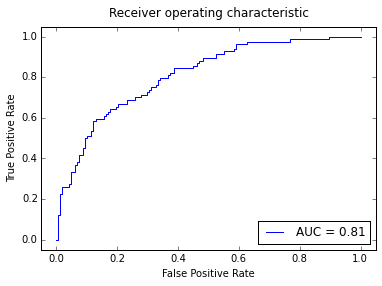

In [14]:
probas_ = model.predict_proba(test_pd.iloc[:,:8])
plot_roc(test_pd.iloc[:,8], probas_[:,1],  lib='' )

## 2.3 Simple tests of the online learning function "observe"

1. Randomly generate one input array and append it to the training data
2. Run "observe" function to update the Naive Bayers model
3. Use the updated model to make prediction on the original test data
4. Track the prediction accuracy as new data added
5. **Repeat Step 1 - 4**
6. Compare the results from Method 1 and Method 2

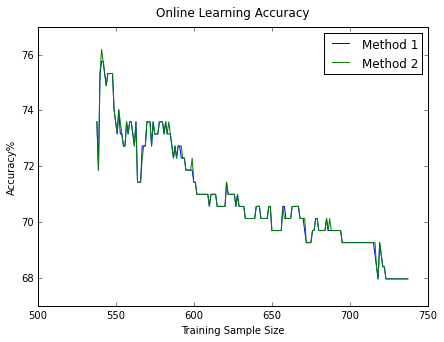

In [15]:
accuracyList_v1 = []
accuracyList_v2 = []

# make a deep copy of Naive Bayers instance
tempModel = copy.deepcopy(nb_model)

for i in xrange(200):
    # random sample data generator
    newOb = [random.randint(0,100) for x in xrange(8)]
    label = 1 if random.random() > 0.4 else 0
    
    if Debug:
        print nb_model._model, nb_model.prior, nb_model.trainSize
        print tempModel._model, tempModel.prior, tempModel.trainSize
    
    nb_model.observe_sanityCheck(newOb[:], label, trainingData)
    accuracyList_v1.append(nb_model.validation(testData))
    
    tempModel.observe(newOb[:], label)
    accuracyList_v2.append(tempModel.validation(testData))
    

plt.figure(figsize=(7,5))
accuracyList_v1 = pd.DataFrame(accuracyList_v1, columns=['Training Sample Size', 'Accuracy'])
plt.plot(accuracyList_v1['Training Sample Size'], accuracyList_v1['Accuracy'], label='Method 1')

accuracyList_v2 = pd.DataFrame(accuracyList_v2, columns=['Training Sample Size', 'Accuracy'])
plt.plot(accuracyList_v2['Training Sample Size'], accuracyList_v2['Accuracy'], label='Method 2')
plt.title('Online Learning Accuracy', y=1.02)
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy%')
plt.legend(loc='best')
plt.show()


### 2.3.1 Sanity check of two "observe" methods

In [16]:
eq = (accuracyList_v1 == accuracyList_v2).any(1)

for x in eq:
    assert x, 'Two methods does not give the identical results!'